# Ensemble Learning Exercise

## 1. Implementing Random Forest From Scratch (30 points)
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your model will handle **continuous input and output**. 

* Compelete the skeleton class below (you should use scikit-learn's `DecisionTreeRegressor` model that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `n_features` is the size of features to sample. This can be a natrual number > 0, or a ratio of the features as a number in range (0,1]
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  

* The `predict` function will use mean of the target values of the trees. The result is a vector of predictions matching the number of rows in `X`.

* The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

* To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
 


In [1]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

In [2]:

class TreeEnsemble():
    def __init__(self, X, y, n_trees, sample_sz, n_features, min_leaf):
        self.X_train = X
        self.y_train = y
        self.n_trees = n_trees
        self.sample_sz = sample_sz #size of sample set to use of each of the trees
        self.n_features = n_features #size of the features to sample
        self.min_leaf = min_leaf
        self.estimators_info = []
        
        self.fit()
        
    def fit(self):
        for number_tree in range(self.n_trees):
            subset_X, subset_y, samples_indexes, features_indexes = self.create_subset_data()
            clf =  DecisionTreeRegressor(min_samples_leaf=self.min_leaf)
            clf.fit(subset_X, subset_y)
            self.estimators_info.append((clf, samples_indexes, features_indexes))
    
    def create_subset_data(self):
        samples_indexes = np.random.choice(self.X_train.shape[0], size=self.sample_sz, replace=True)
        subset_X = self.X_train[samples_indexes]
        subset_y = self.y_train[samples_indexes]

        features_indexes = np.random.choice(self.X_train.shape[1], size=self.n_features, replace=True)
        subset_X = subset_X[:,features_indexes]
        return subset_X, subset_y, samples_indexes, features_indexes
        

    def predict(self, X):
        predict_by_estimator = np.zeros((X.shape[0], self.n_trees))
        
        for estimator_index in range(len(self.estimators_info)):
            model, samples_indexes, features_indexes = self.estimators_info[estimator_index]
            y_predict = model.predict(X[:, features_indexes])
            predict_by_estimator[:, estimator_index] = y_predict
        prediction = np.mean(predict_by_estimator, axis=1)
        return prediction
        
        
    def find_oob_indexes(self):
        oob_all_indexes = set()
        
        for model, samples_indexes, features_indexes in self.estimators_info:
            all_indexes = np.arange(self.X_train.shape[0])
            oob_indexes = np.delete(all_indexes, samples_indexes)
            oob_all_indexes.update(oob_indexes)     
        return oob_all_indexes
            
        
    def oob_mse(self):
        oob_all_indexes = self.find_oob_indexes()
        mse = []
        
        for oob_index in oob_all_indexes:
            y_predicts = []
            y_true = self.y_train[oob_index]
            for model, samples_indexes, features_indexes in self.estimators_info:
                if oob_index not in samples_indexes:
                    sample = self.X_train[oob_index]
                    y_predict = model.predict(sample[features_indexes].reshape(1, -1))
                    y_predicts.append(y_predict)
            mse.append(np.square(np.mean(y_predicts) - y_true))
        return np.mean(mse)

In [3]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
#find good number of features
from sklearn.metrics import mean_squared_error

best_n_features = 0
best_mse = np.inf

for i in range(2, X_train.shape[1]):
    descition_tree = DecisionTreeRegressor(max_features=i)
    descition_tree.fit(X_train, y_train)
    y_predict = descition_tree.predict(X_test)
    mse = mean_squared_error(y_test, y_predict)
    if mse < best_mse:
        best_mse = mse
        best_n_features = i
print(f'Best mse: {best_mse}, best number of features: {best_n_features}')

Best mse: 10.750314960629922, best number of features: 12


In [5]:
mse_details = (np.inf, 0, 0, 0)

for n in [1, 5, 10, 20, 50, 100]:
    for sz in [50, 100, 300, 500]:
        for min_leaf in [1,5]:
            forest = TreeEnsemble(X_train, y_train, n, sz, 9, min_leaf)
            mse = forest.oob_mse()
            print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
            if mse < mse_details[0]:
                mse_details = (mse, n, sz, min_leaf)
print()
print(f'Best mse: {mse_details[0]}, n trees: {n}, size samples: {sz}, min leaf: {min_leaf}')

n_trees:1, sz:50, min_leaf:1 --- oob mse: 86.7753313253012
n_trees:1, sz:50, min_leaf:5 --- oob mse: 75.28665300436387
n_trees:1, sz:100, min_leaf:1 --- oob mse: 45.25551724137931
n_trees:1, sz:100, min_leaf:5 --- oob mse: 28.45186909109173
n_trees:1, sz:300, min_leaf:1 --- oob mse: 20.514189944134074
n_trees:1, sz:300, min_leaf:5 --- oob mse: 30.58436453326139
n_trees:1, sz:500, min_leaf:1 --- oob mse: 92.0197894736842
n_trees:1, sz:500, min_leaf:5 --- oob mse: 40.728960045571625
n_trees:5, sz:50, min_leaf:1 --- oob mse: 28.047774728818528
n_trees:5, sz:50, min_leaf:5 --- oob mse: 29.337475245890268
n_trees:5, sz:100, min_leaf:1 --- oob mse: 20.757548394898855
n_trees:5, sz:100, min_leaf:5 --- oob mse: 29.628929135908855
n_trees:5, sz:300, min_leaf:1 --- oob mse: 24.02615891364902
n_trees:5, sz:300, min_leaf:5 --- oob mse: 27.69721662584976
n_trees:5, sz:500, min_leaf:1 --- oob mse: 30.061834493911714
n_trees:5, sz:500, min_leaf:5 --- oob mse: 30.500121968967076
n_trees:10, sz:50, min

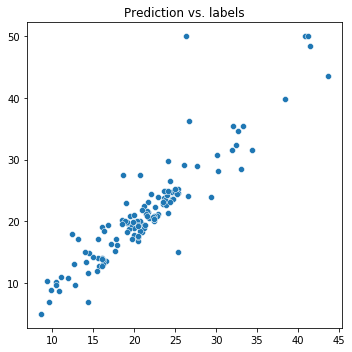

In [6]:
import seaborn as sns
plt.figure(figsize=(5,5))
forest = TreeEnsemble(X_train, y_train, n_trees=100, sample_sz=500, n_features=9, min_leaf=5)
y_hat = forest.predict(X_test)  # forest is the chosen model
sns.scatterplot(x=y_hat, y=y_test)
plt.title("Prediction vs. labels")
plt.tight_layout()

## 2. Implementing AdaBoost From Scratch (30 points)


*   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).
*   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, use a ***linear*** SVM classifier (use `LinearSVC` with the default parameters)
      **changed to Stump tree**
    - Split the sample set into train and test sets.
    - Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?



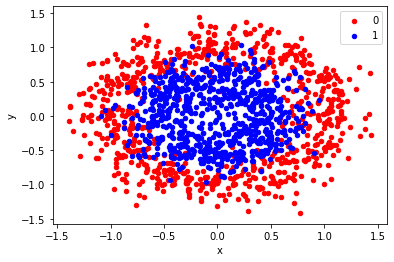

In [7]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [8]:
from sklearn.tree import DecisionTreeClassifier

def create_weak_learner():
    return DecisionTreeClassifier(max_depth=1)

In [9]:
class AdaBoost():
    def __init__(self, n_learners, create_weak_learner_method):
        self.n_learners = n_learners
        self.create_weak_learner_method = create_weak_learner_method
        self.estimators = []
        
    def fit(self, X, y):
        self.init_params(X, y)
        
        for iteration in range(self.n_learners):
            estimator = self.create_weak_learner_method()
            y_predictions = self.create_weighted_estimation(estimator)
            error = self.calc_error(y_predictions)
            alpha = 0.5*np.log((1-error) / error)
            
            converted_predict_y = y_predictions.copy()
            converted_predict_y[converted_predict_y==0] = -1
            new_weights = self.weights * np.exp(-alpha * self.converted_y * converted_predict_y)
            self.weights = new_weights / (np.sum(new_weights))
            self.estimators.append((estimator, alpha))
        
    def init_params(self, X, y):
        self.X_train = X
        self.y_train = y
                
        converted_y = y.copy()
        converted_y[converted_y==0] = -1
        self.converted_y = converted_y
        
        self.weights = np.full(self.X_train.shape[0], (1/self.X_train.shape[0]))
       
    
    def create_weighted_estimation(self, estimator):
        #we want to give priority to high weights so we will sample them with higher chance to create
        # a stump tree that "more consider" the high errors
        weight_indexes = np.random.choice(self.X_train.shape[0], size= self.X_train.shape[0], 
                                              replace=True, p=self.weights)
        X_by_weights = self.X_train[weight_indexes]
        y_by_weights = self.y_train[weight_indexes]
        estimator.fit(X_by_weights, y_by_weights)
        y_predict = estimator.predict(self.X_train)
        return y_predict
    
    def calc_error(self, y_predictions):
        not_equal = y_predictions != self.y_train
        error = np.sum(self.weights[not_equal])
        return error
    
    def predict(self, X):
        prediction = np.zeros(X.shape[0])

        for estimator, alpha in self.estimators:
            est_predict = estimator.predict(X)
            est_predict[est_predict==0] = -1
            prediction += alpha * est_predict

        prediction[prediction >= 0] = 1
        prediction[prediction < 0] = 0
        return prediction

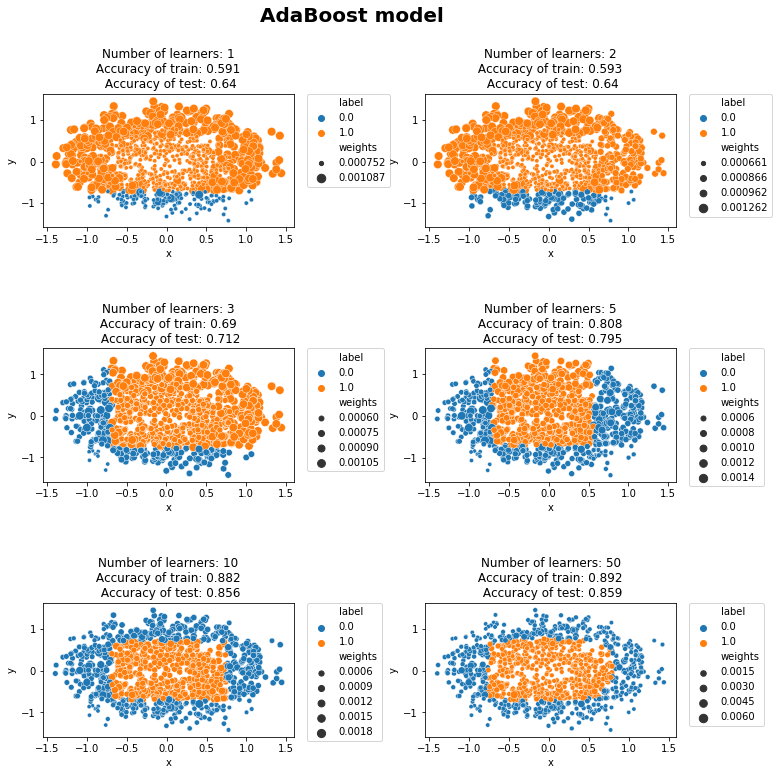

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.tight_layout(pad= 10.0)
fig.suptitle('AdaBoost model',fontsize=20, fontweight ="bold")

accuracy_train_scores = []
count_row = 0
count_col = 0
for n in [1, 2, 3, 5, 10, 50]:
    clf = AdaBoost(n_learners=n, create_weak_learner_method=create_weak_learner)
    clf.fit(train_x, train_y)
    y_train_predict = clf.predict(train_x)
    y_test_predict = clf.predict(test_x)
    
    score_train = round(accuracy_score(train_y, y_train_predict),3)
    score_test = round(accuracy_score(test_y, y_test_predict),3)
    
    df = DataFrame({'x': train_x[:,0], 'y': train_x[:,1], 'label': y_train_predict, 'weights': 
                    np.round(clf.weights,6)})
    sns.scatterplot(ax=axes[count_row, count_col], data=df, x="x", y="y", hue="label", size="weights").set_title(
        f'Number of learners: {n}\n Accuracy of train: {score_train} \n Accuracy of test: {score_test}')
    axes[count_row, count_col].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    accuracy_train_scores.append(score_train)
    
    count_col += 1
    if count_col % 2 == 0:
        count_row +=1
        count_col = 0

#### How does the overall train set accuracy changes with  𝑛 ?

As we can see from the graph, in the beggining the number of learners has meaningful influence on train set accuracy but when the number of learners is high it's influence just a bit.

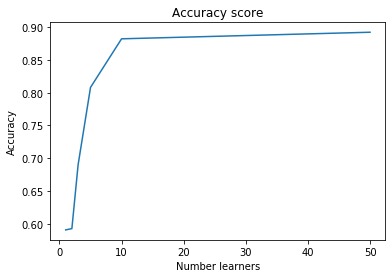

In [11]:
n_learners = [1, 2, 3, 5, 10, 50]
ax = sns.lineplot(x=n_learners, y=accuracy_train_scores)
ax.set(xlabel = "Number learners", ylabel = "Accuracy", title="Accuracy score")
plt.show()

#### Does your model starts to overfit at some point?
On this iteration we can't see an overfit.
But, in some random checks we saw that the model is beggining to overfit, we recognized it from the accuracy of the test train. On the graphs above, the test set accuracy was higher on 10 learners then 50 learners but the train accuracy is the opposite- on 50 learners it was higher then 10 learners.

## 3. Boosting Trees from Scratch (40 points)
* Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
* Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
* Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
* Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [12]:
class L2Boost():
    
    def __init__(self, n_learners, learning_rate, max_depth=1):
        self.n_learners = n_learners
        self.learning_rate = learning_rate
        self.estimators = []
        self.mse = []
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.prediction = np.full(self.X_train.shape[0], np.mean(self.y_train))
        
        for iteration in range(self.n_learners):
            residuals = self.y_train - self.prediction
            estimator = self.create_estimator()
            estimator.fit(self.X_train, residuals)
            residual_pred = estimator.predict(self.X_train)
            self.prediction += self.learning_rate * residual_pred
            self.mse.append(mean_squared_error(y_true=self.y_train, y_pred=self.prediction))
            self.estimators.append(estimator)
            
    def predict(self, X):
        predicts= np.full(X.shape[0], np.mean(self.y_train))
        
        for estimator in self.estimators:
            residual_predicts = estimator.predict(X)
            predicts += self.learning_rate * residual_predicts
        return predicts
    
    def create_estimator(self):
        #we use random state to be able to compare between the model to deep decision tree. 
        return DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)

#### Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of n_trees up to 1,000

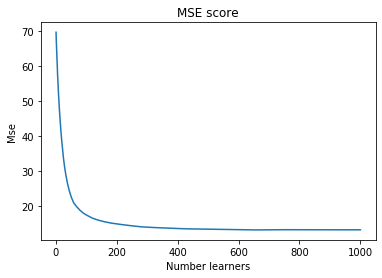

The optimal n_learners: 655, with mse: 13.126821962759038


In [13]:
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

n_learners_logspace = np.unique(np.logspace(0, 3, endpoint=True, dtype=np.int64))
mse_scores = []

for n_learners in n_learners_logspace:
    clf = L2Boost(n_learners, learning_rate=0.05)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    mse = mean_squared_error(y_true=y_test, y_pred=y_predict)
    mse_scores.append(mse)
    
ax = sns.lineplot(x=n_learners_logspace, y=mse_scores)
ax.set(xlabel = "Number learners", ylabel = "Mse", title="MSE score")
plt.show()

best_index = np.argmin(mse_scores)
print(f'The optimal n_learners: {n_learners_logspace[best_index]}, with mse: {mse_scores[best_index]}')

#### What is the optimal value of n_trees? of learning rate?

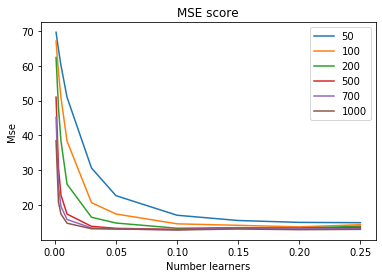

The optimal learning rate: 0.1, with n_learners: 1000, and mse: 12.885662545026955


In [14]:
import pandas as pd

lerning_rates = [0.25, 0.2, 0.15, 0.1, 0.05, 0.03, 0.01, 0.005, 0.003, 0.001]
n_learners_list = [50, 100, 200, 500, 700, 1000]

df = pd.DataFrame(columns=n_learners_list, index = lerning_rates)

for n_learners in n_learners_list:
    mse_scores = []
    for lr in lerning_rates:
        clf = L2Boost(n_learners, learning_rate=lr)
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        mse = mean_squared_error(y_true=y_test, y_pred=y_predict)
        mse_scores.append(mse)
    df.loc[:, n_learners] = mse_scores
    ax = sns.lineplot(x=lerning_rates, y=mse_scores)

ax.set(xlabel = "Number learners", ylabel = "Mse", title="MSE score")
plt.legend(labels=n_learners_list)
plt.show()

best_index = np.argmin(mse_scores)
print(f'The optimal learning rate: {lerning_rates[best_index]}, with n_learners: {n_learners_list[-1]}, and mse: {mse_scores[best_index]}')

In [15]:
df

,50,100,200,500,700,1000
0.250,14.9571,14.3738,13.934,13.5775,13.2318,13.0468
0.200,15.0469,13.7639,13.4037,13.3698,13.2286,12.9534
0.150,15.5868,14.2012,13.5353,13.4553,13.4062,13.145
0.100,17.0935,14.6317,13.3674,13.029,12.9346,12.8857
0.050,22.7163,17.4539,14.8626,13.3445,13.1498,13.1537
0.030,30.6464,20.7068,16.5175,13.9141,13.4519,13.2134
0.010,50.9297,38.3801,26.01,17.4298,15.8812,14.8124
0.005,60.1537,50.9051,38.4436,22.9221,19.6265,17.4562
0.003,64.6608,58.0656,47.9423,30.8167,25.3404,20.8211
0.001,69.5963,67.0412,62.352,50.9661,45.2086,38.4656


For all the number of learners we get an elbow graph, while the learning rate is too low the mse start to raise. In addition when the learning rate is too high the mse raise up as well. The meaning is that we need to take a learning rate that helps us to converge. The best learning rate is 0.1 with 1000 learners.

#### Compare the performance with a deep DecisionTreeRegressor (find the optimal max_depth). Who wins?

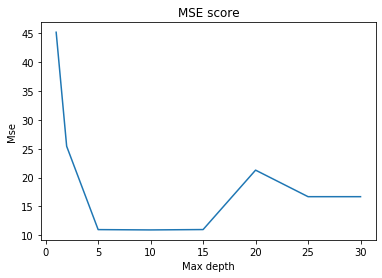

The optimal max_depth: 10, with mse: 10.93079922475262


In [16]:
max_depth_list = [1, 2, 5, 10, 15, 20, 25, 30, None]
mse_scores = []

for max_depth in max_depth_list:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)
    y_predict = dt.predict(X_test)    
    mse = mean_squared_error(y_true=y_test, y_pred=y_predict)
    mse_scores.append(mse)
    
ax = sns.lineplot(x=max_depth_list, y=mse_scores)
ax.set(xlabel = "Max depth", ylabel = "Mse", title="MSE score")
plt.show()

best_index = np.argmin(mse_scores)
print(f'The optimal max_depth: {max_depth_list[best_index]}, with mse: {mse_scores[best_index]}')

We got that the deep descition tree is a little bit better then the gradient L2Boost. But in a general case the decision tree tends to overfit and may create results that are worst for the test set, so we will prefer to use the L2Boost. 

#### Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [17]:
#To create an early stop we need to stop when we converge.
# in this model we have learning rate to avoid of overfit to the train data
# so we can define that the early stop will be when we get x times to kind of loca


class L2Boost2():
    
    def __init__(self, n_learners, learning_rate, max_depth=1):
        self.n_learners = n_learners
        self.learning_rate = learning_rate
        self.estimators = []
        self.mse = []
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.prediction = np.full(self.X_train.shape[0], np.mean(self.y_train))
        
        for iteration in range(self.n_learners):
            residuals = self.y_train - self.prediction
            estimator = self.create_estimator()
            estimator.fit(self.X_train, residuals)
            residual_pred = estimator.predict(self.X_train)
            self.prediction += self.learning_rate * residual_pred
            self.mse.append(mean_squared_error(y_true=self.y_train, y_pred=self.prediction))
            self.estimators.append(estimator)

    def validate(self, X, y, number_local_min=150, early_stop=True):
        predicts= np.full(X.shape[0], np.mean(self.y_train))
        predictions = []
        mse_list = []
        number_of_iterations = 0
        count_local_min = 0
        
        for estimator in self.estimators:
            residual_predicts = estimator.predict(X)
            predicts += self.learning_rate * residual_predicts
            mse = mean_squared_error(y_true=y, y_pred=predicts)
            mse_list.append(mse)
            
            if early_stop and len(mse_list) > 1:
                if mse_list[-2] - mse_list[-1] < 0:
                    count_local_min +=1
                if count_local_min > number_local_min:
                    print(f"Early stopped after {number_of_iterations} iterations")
                    self.estimators = self.estimators[:number_of_iterations]
                    self.mse = self.mse[:number_of_iterations]
                    break
            number_of_iterations += 1
            predictions.append(predicts)
        return predictions[-1]
                
            
    def predict(self, X):
        predicts= np.full(X.shape[0], np.mean(self.y_train))
        
        for estimator in self.estimators:
            residual_predicts = estimator.predict(X)
            predicts += self.learning_rate * residual_predicts
        return predicts
    
    def create_estimator(self):
        #we use random state to be able to compare between the model to deep decision tree. 
        return DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)

In [18]:
#to check our early stop we will use the best n_learners we found
X, y = load_boston(return_X_y=True)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

clf2 = L2Boost2(1000, learning_rate=0.05)
clf2.fit(X_train, y_train)
y_predict = clf2.validate(X_valid, y_valid)
mse = mean_squared_error(y_true=y_valid, y_pred=y_predict)
print(f'train mse: {clf2.mse[-1]} , validation mse: {mse}')

Early stopped after 600 iterations
train mse: 6.888258392877423 , validation mse: 13.207042918549154


As we can see, there was an early stop after 601 iterations out of 1000.